In [4]:
from typing import Union
from collections import defaultdict
from itertools import combinations
import numpy as np
import cv2
from skimage.transform import rescale
from skimage.measure import label, find_contours
from skimage.filters import gaussian
from scipy.spatial.distance import cdist
import scipy.stats as st
from operator import itemgetter
from imutils.object_detection import non_max_suppression
import matplotlib.pyplot as plt
import imutils
from scipy.spatial import distance as dist
from imutils import perspective
from imutils import contours
%matplotlib inline

In [5]:
def plot_img(img, cmap='gray'):
    plt.figure(figsize=(10, 10))
    plt.imshow(img.astype(np.float32), cmap=cmap)
    plt.axis('off')
    plt.show()

In [6]:
class TempMatch():
    def __init__(self, city_template):
        #self.city_template = cv2.imread('template.jpg', 0)
        self.city_template = city_template
        self.w = city_template.shape[::-1][0]
        self.h = city_template.shape[::-1][1]
        self.boxes = list()
        
    

    def match(self, img):
        #template matching
        count = 0
        imgray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        res = cv2.matchTemplate(imgray.astype(np.uint8),self.city_template.astype(np.uint8),cv2.TM_CCOEFF_NORMED)
        threshold = 0.58

        (y_points, x_points) = np.where(res >= threshold)

        # REinitialize our list of bounding boxes
        self.boxes = list()
        # store co-ordinates of each bounding box
        # we'll create a new list by looping
        # through each pair of points
        for (x, y) in zip(x_points, y_points):

            self.boxes.append((x, y, x + self.w, y + self.h))

        self.boxes = np.array(self.boxes)

        # loop over the final bounding boxes
        
        for (x1, y1, x2, y2) in self.boxes:

            # draw the bounding box on the image
            cv2.rectangle(img, (x1, y1), (x2, y2),(255, 0, 0), 3)
            count += 1
        obj_num = count
        return [self.boxes[:,1], self.boxes[:,0]], obj_num, img, self.boxes



In [7]:
#Detect cities and get the coordinates of city centers
def city_coord(img):
    city_template = cv2.imread('template.jpg', 0)
    match = TempMatch(city_template)
    result_match = match.match(img)
    coord = result_match[0]

    # Collect the coordinates of the center
    center_coord = []

    for i in range (len(coord[0])):
        center_x = coord[0][i] + 0.5*match.w
        center_y = coord[1][i] + 0.5*match.h
        center_coord.append((center_x, center_y))

    coord_sort = sorted(center_coord,key=lambda l:l[0])
    return coord_sort

city_cntrs = city_coord(cv2.imread('black_blue_green.jpg'))
city_cntrs



[(171.0, 2178.0),
 (171.0, 2179.0),
 (171.0, 2180.0),
 (172.0, 2177.0),
 (172.0, 2178.0),
 (172.0, 2179.0),
 (172.0, 2180.0),
 (173.0, 2177.0),
 (173.0, 2178.0),
 (173.0, 2179.0),
 (173.0, 2180.0),
 (174.0, 2177.0),
 (174.0, 2178.0),
 (174.0, 2179.0),
 (174.0, 2180.0),
 (175.0, 2178.0),
 (175.0, 2179.0),
 (175.0, 2180.0),
 (246.0, 3251.0),
 (246.0, 3252.0),
 (246.0, 3253.0),
 (246.0, 3254.0),
 (247.0, 3250.0),
 (247.0, 3251.0),
 (247.0, 3252.0),
 (247.0, 3253.0),
 (247.0, 3254.0),
 (248.0, 3250.0),
 (248.0, 3251.0),
 (248.0, 3252.0),
 (248.0, 3253.0),
 (248.0, 3254.0),
 (249.0, 3250.0),
 (249.0, 3251.0),
 (249.0, 3252.0),
 (249.0, 3253.0),
 (249.0, 3254.0),
 (250.0, 3250.0),
 (250.0, 3251.0),
 (250.0, 3252.0),
 (250.0, 3253.0),
 (250.0, 3254.0),
 (251.0, 3250.0),
 (251.0, 3251.0),
 (251.0, 3252.0),
 (251.0, 3253.0),
 (252.0, 3251.0),
 (254.0, 641.0),
 (254.0, 642.0),
 (254.0, 643.0),
 (254.0, 644.0),
 (255.0, 641.0),
 (255.0, 642.0),
 (255.0, 643.0),
 (255.0, 644.0),
 (256.0, 641.0),
 

In [8]:
thresh = 50
filtered_centers = []

for i in range (len(city_cntrs) - 1):
    if not np.all(np.sqrt((np.array(city_cntrs[i])- np.array(city_cntrs[i+1]))**2) < thresh):
        filtered_centers.append(city_cntrs[i])
filtered_centers.append(city_cntrs[i+1])

len(filtered_centers)

45

In [9]:
import json

len(json.load(open('black_blue_green_centers.json')))

46

In [10]:
np.array((444.0, 1775.0)) - np.array((590.0, 2282.0))

array([-146., -507.])

In [11]:
# Filter too small contours

def contour_filter(contours, hierarchy, minArea):
    cnts1 = []
    for i in range(len(contours)):
        if hierarchy[0][i][3] == -1 and cv2.contourArea(contours[i]) > minArea:
            cnts1.append(contours[i])
    return cnts1

# Detect contours 
def contours(img, minArea):
    contours, hierarchy = cv2.findContours(img,
                                            cv2.RETR_TREE,
                                            cv2.CHAIN_APPROX_SIMPLE)

    cnts = contour_filter(contours, hierarchy, minArea)

    #draw contours
    cv2.drawContours(img, cnts, -1, (255,0,0), 3) 
    cv2.imwrite('cnts.png', img)
    return cnts, hierarchy, img

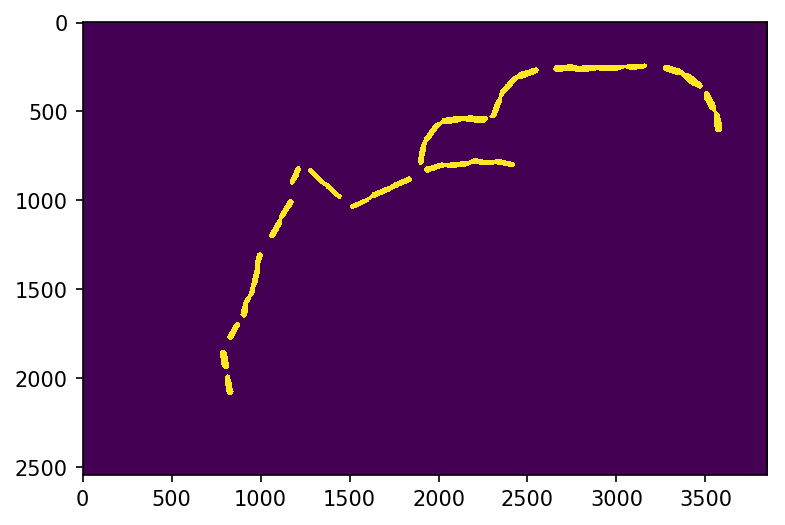

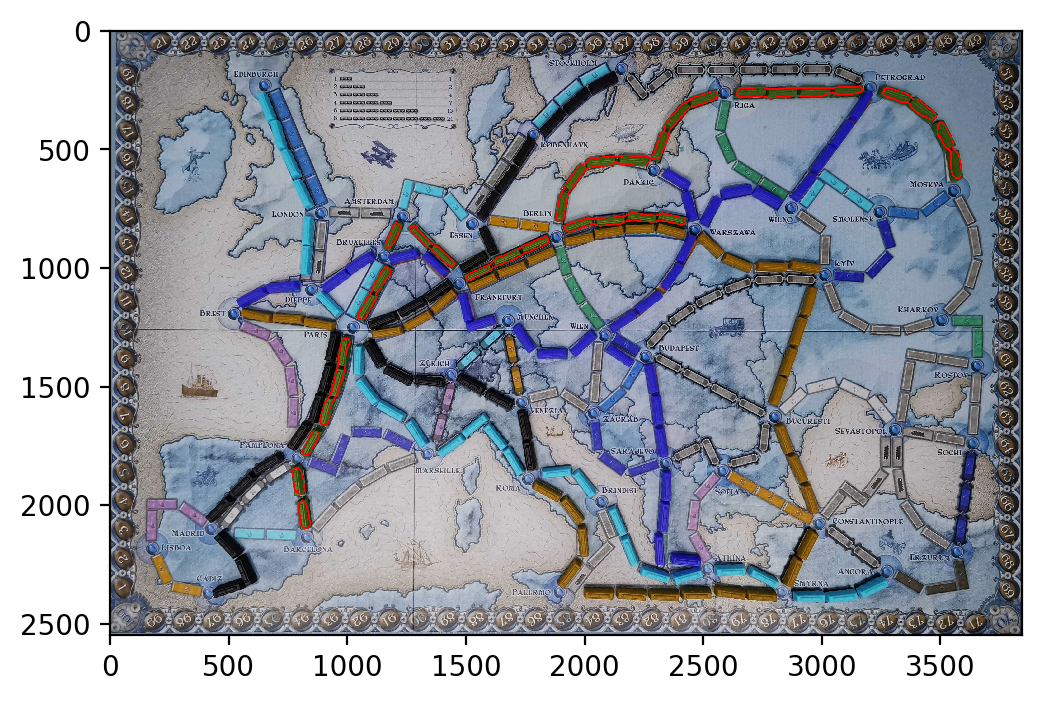

In [12]:

#filter green color

def filter_green(img, k=9, g_blur=3, m_blur=11):
    image = img
    
    img = cv2.GaussianBlur(img,(g_blur,g_blur),0)
    img = img[..., ::-1]
    #------------------------------------
    HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)


    l_range = np.array([75, 160,50 ])
    u_range = np.array([83, 255,145 ])
    #green mask
    mask_green = cv2.inRange(HSV, l_range, u_range)
    mask_int_green = mask_green.astype(np.uint8)
    kernel = np.ones((k,k))
    mask_int_green = cv2.morphologyEx(mask_int_green, cv2.MORPH_CLOSE, kernel)
    mask_int_green = cv2.medianBlur(mask_int_green,m_blur)

    return mask_int_green

img = cv2.imread('all.jpg')
plt.figure(dpi=150)
green_mask = filter_green(img.copy(), k=23, g_blur=1, m_blur=27) # 23, 1, 27
plt.imshow(green_mask)

cnts, _, _ = contours(green_mask.copy(), 1000)
plt.figure(dpi=200)
plt.imshow(cv2.drawContours(img.copy(), cnts, -1, (255,0,0), 5) )

plt.show()



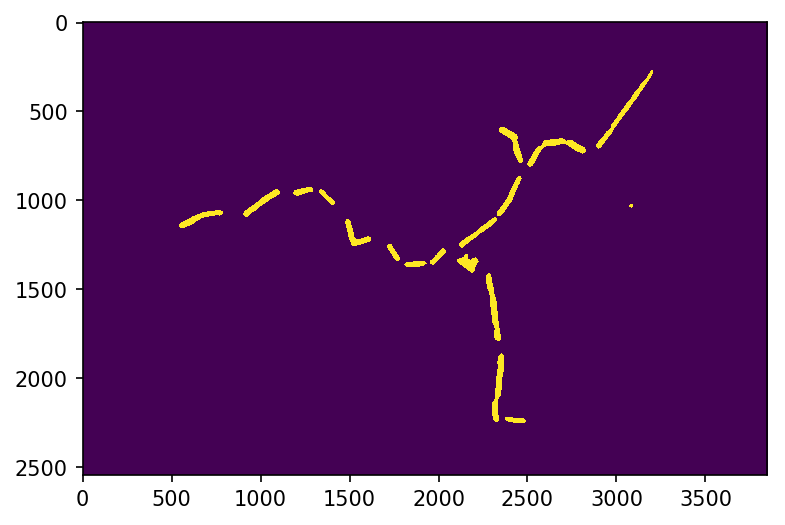

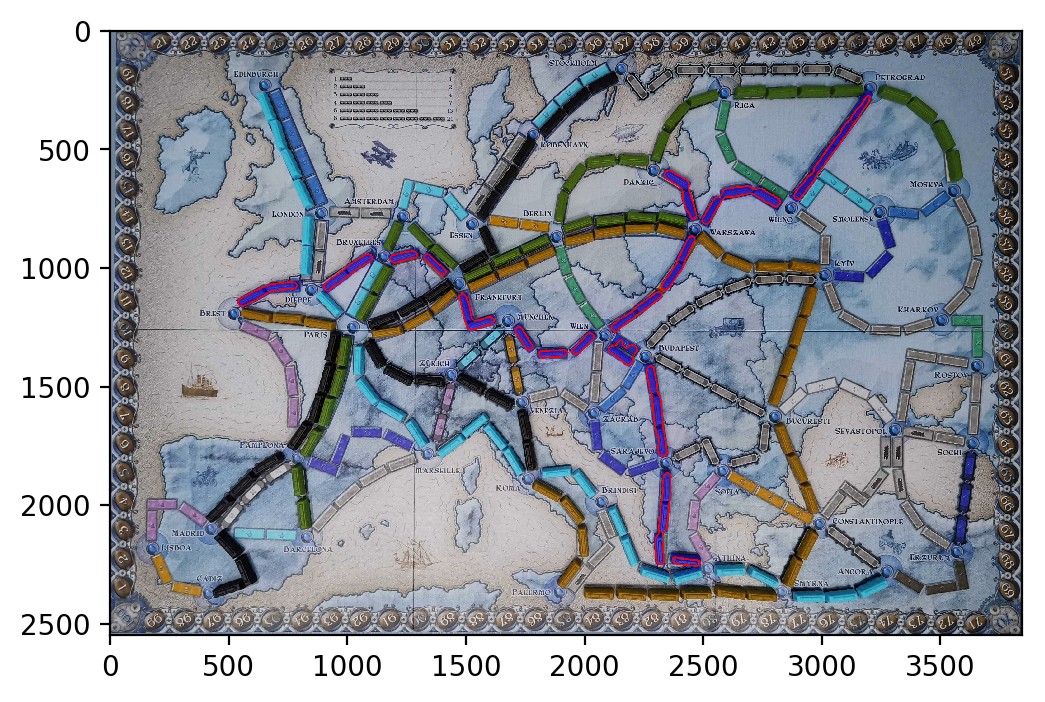

In [13]:

#filter red color

def filter_red(img, k=9, g_blur=3, m_blur=11):
  
    
    image = img
    rgb = cv2.cvtColor(image.copy(), cv2.COLOR_BGR2RGB )
    Img = cv2.GaussianBlur(image,(g_blur,g_blur),0)
    Img = Img[..., ::-1]
    #------------------------------------
    HLS = cv2.cvtColor(Img, cv2.COLOR_BGR2HLS)
    HUE = HLS[:, :, 0]              # Split attributes
    LIGHT = HLS[:, :, 1]
    SAT = HLS[:, :, 2]

    
    l_range = np.array([121, 86, 148])
    u_range = np.array([132, 148, 190])
    #red mask
    mask_red = cv2.inRange(HLS, l_range, u_range)
    mask_int_red = mask_red.astype(np.uint8)
    kernel = np.ones((k,k))
    mask_int_red = cv2.morphologyEx(mask_int_red, cv2.MORPH_CLOSE, kernel)
    mask_int_red = cv2.medianBlur(mask_int_red,m_blur)

    return mask_int_red

img = cv2.imread('all.jpg')
plt.figure(dpi=150)
red_mask = filter_red(img.copy(), k=23, g_blur=1, m_blur=27) # 23, 1, 27
plt.imshow(red_mask)

cnts, _, _ = contours(red_mask.copy(), 1000)
plt.figure(dpi=200)
plt.imshow(cv2.drawContours(img.copy(), cnts, -1, (255,0,0), 5) )

plt.show()


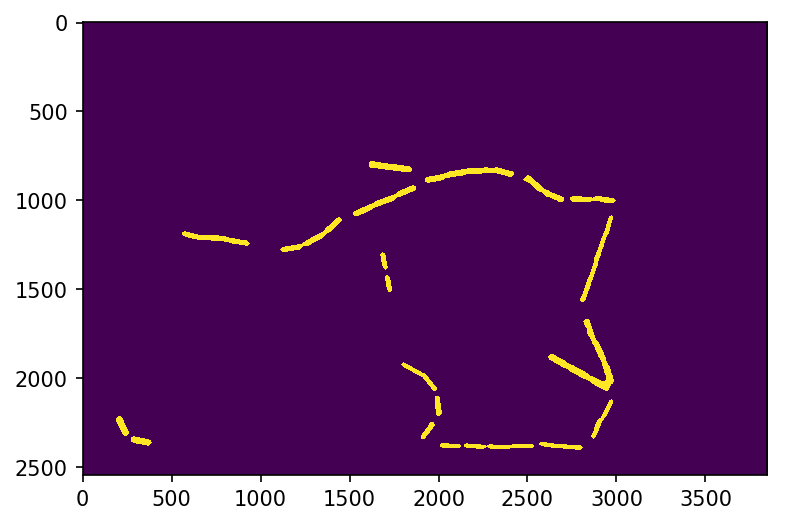

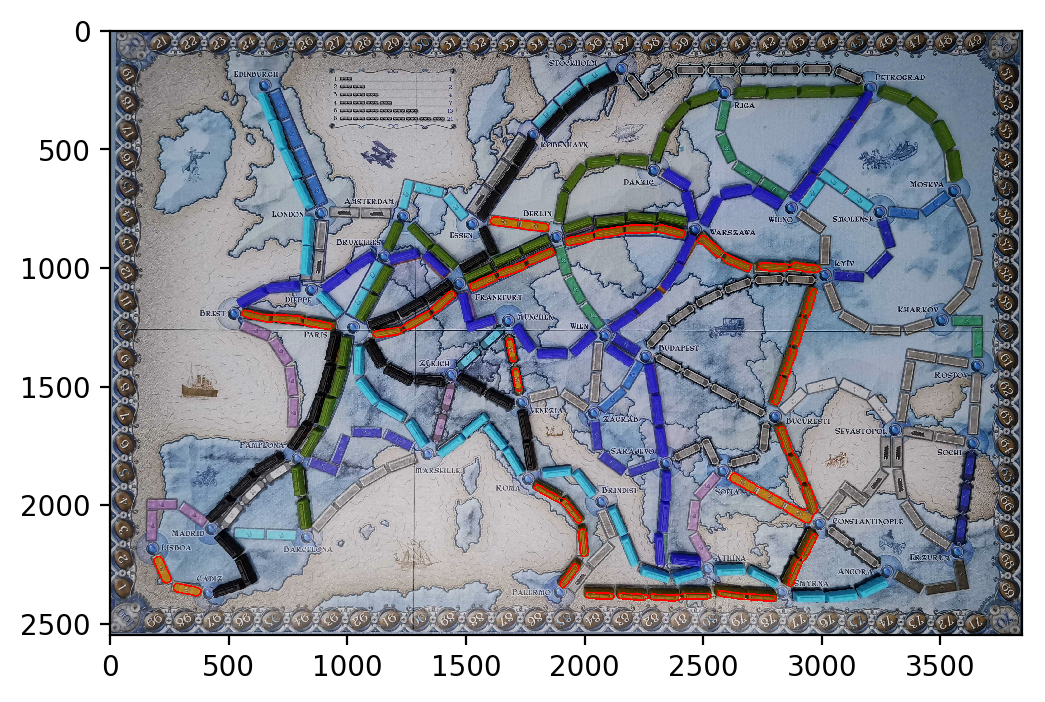

In [14]:
#filter blue color

def filter_blue(img, k=9, g_blur=3, m_blur=11):
    
    image = img
    #------------------------------------
    img = cv2.GaussianBlur(img,(g_blur,g_blur),0)
    img = img[..., ::-1]
    #------------------------------------
    HSV = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    l_range = np.array([100, 150,110 ])
    u_range = np.array([120, 255,180 ])
    #blue mask
    mask_blue = cv2.inRange(HSV, l_range, u_range)
    mask_blue = cv2.medianBlur(mask_blue, 3)
    mask_int_blue = mask_blue.astype(np.uint8)
    kernel = np.ones((k,k))
    mask_int_blue = cv2.morphologyEx(mask_int_blue, cv2.MORPH_CLOSE, kernel)
    mask_int_blue = cv2.medianBlur(mask_int_blue,m_blur)
    

    return mask_int_blue


img = cv2.imread('all.jpg')
plt.figure(dpi=150)
blue_mask = filter_blue(img.copy(), k=23, g_blur=1, m_blur=27) # 23, 1, 27
plt.imshow(blue_mask)

cnts, _, _ = contours(blue_mask.copy(), 1000)
plt.figure(dpi=200)
plt.imshow(cv2.drawContours(img.copy(), cnts, -1, (255,0,0), 5) )

plt.show()

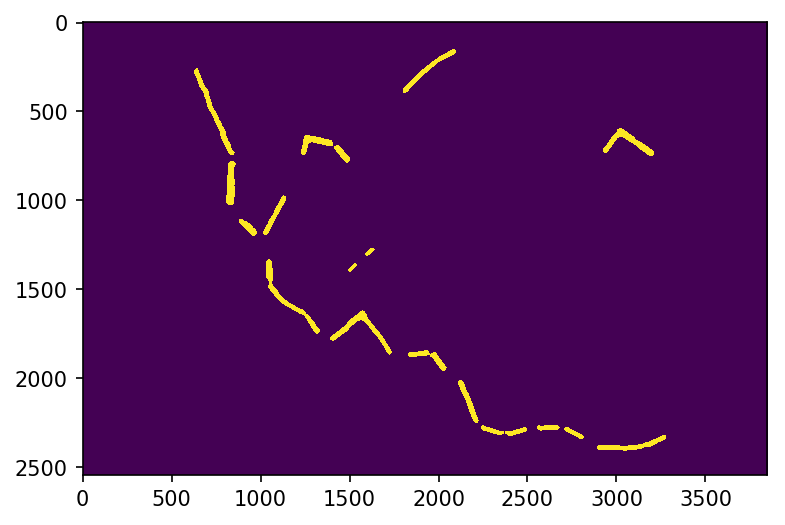

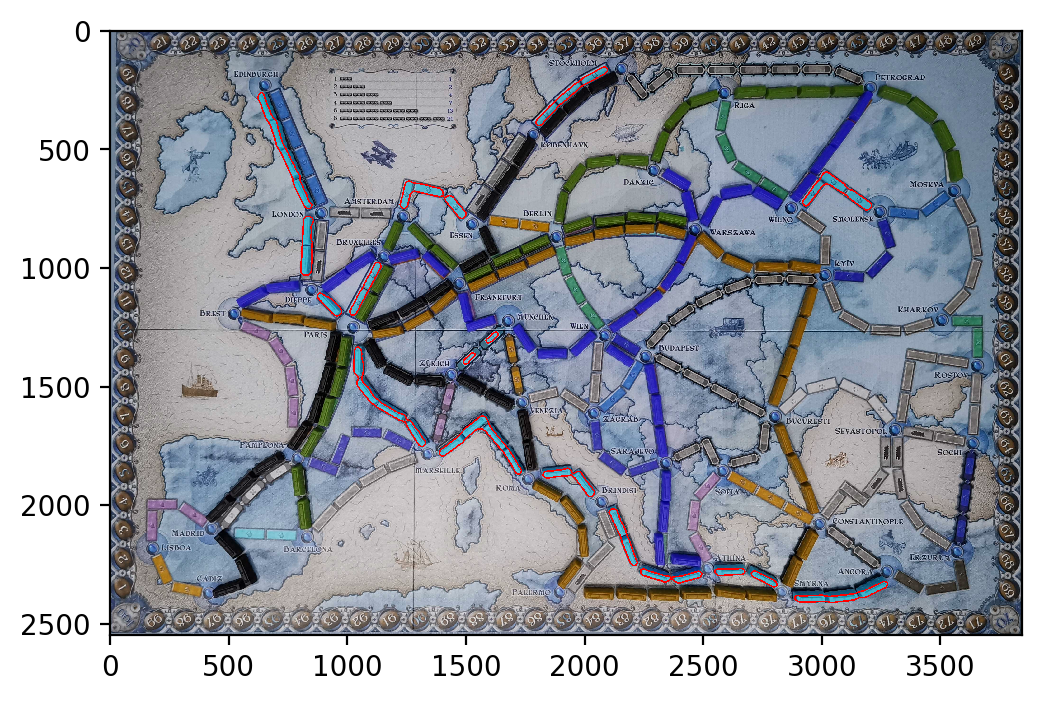

In [15]:
#filter yellow color

def filter_yellow(img, k, g_blur, m_blur):
    
    img = cv2.GaussianBlur(img,(g_blur,g_blur),0)
    img = img[..., ::-1]
    #------------------------------------
    HSV = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
   

    l_range = np.array([65, 96, 103])
    u_range = np.array([105, 157, 191])
    #yellow mask
    mask_yellow = cv2.inRange(HSV, l_range, u_range)
    mask_yellow = cv2.medianBlur(mask_yellow, 3)
    mask_int_yellow = mask_yellow.astype(np.uint8)
    kernel = np.ones((k,k))
    mask_int_yellow = cv2.morphologyEx(mask_int_yellow, cv2.MORPH_CLOSE, kernel)
    mask_int_yellow = cv2.medianBlur(mask_int_yellow,m_blur)

    return mask_int_yellow

img = cv2.imread('all.jpg')
plt.figure(dpi=150)
yellow_mask = filter_yellow(img.copy(), k=23, g_blur=1, m_blur=27) # 23, 1, 27
plt.imshow(yellow_mask)

cnts, _, _ = contours(yellow_mask.copy(), 500)
plt.figure(dpi=200)
plt.imshow(cv2.drawContours(img.copy(), cnts, -1, (255,0,0), 5) )

plt.show()

In [16]:
#filter yellow color

def filter_black(img):
    k = 19
   
    #------------------------------------
    HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    HUE = HLS[:, :, 0]             
    LIGHT = HLS[:, :, 1]
    SAT = HLS[:, :, 2]
    
    mask_black = (LIGHT < 25)
    mask_int_black = mask_black.astype(np.uint8)
    kernel = np.ones((15,15))
    mask_int_black = cv2.morphologyEx(mask_int_black, cv2.MORPH_CLOSE, kernel)
    kernel = np.ones((19,19))
    mask_int_black = cv2.morphologyEx(mask_int_black, cv2.MORPH_OPEN, kernel)

    return mask_int_black

In [17]:
# Calculate the contours areas

def cnts_area(cnts):
    area = []
    for i in range(len(cnts)):
        area.append(cv2.contourArea(cnts[i]))
    return area

In [18]:
# Get the size of one track
def size_of_track(img, filter_func, minArea):
    cnts = contours(filter_func, minArea)
    size = cnts_area(cnts[0])
    return size



In [19]:

def count_trains(area, one_size):
   n_train = 0
   score = 0
   #max_area = np.max(area)
   min_area = np.min(area)

   for i in range(len(area)):

      size = area[i]/one_size
      #print(size)
      if size < 1:
         n_train += 1
         score += 1
      elif size >=1 and size <2:
         n_train += 2
         score += 2
      elif size >= 2 and size < 3:
         n_train += 3
         score += 4
      elif size >= 3 and size <4:
         n_train += 4
         score += 7
      elif size >= 4 and size < 5:
         n_train += 5
         score += 15
      elif size >=5 and size < 6:
         n_train += 6
         score += 15
      else:
         score += 21
  

   return n_train, score


In [27]:
# The number of green trains
img = cv2.imread('all.jpg')
img_green_tmp = cv2.imread('template_green.jpg')
def count_green(img, img_green_tmp):
    n_green = 0
    green_cnts = contours(filter_green(img.copy(), k=23, g_blur=1, m_blur=27), 1000)
    green__size = size_of_track(img_green_tmp, filter_green(img_green_tmp, k=23, g_blur=1, m_blur=27), 500)
    green_area = cnts_area(green_cnts[0])
    # print(green__size)
    if not green_area:
        n_green==0
    else:
        n_green, score_green = count_trains(green_area, green__size[0] + 1200)
    return n_green, score_green

n_green, score_green = count_green(img, img_green_tmp)
n_green


29

In [21]:


def remove_tracks(img, template, cnts):
    
    match = TempMatch(template)
    result_match = match.match(img)
    img = result_match[2]
    rect = result_match[3]
    coord = result_match[0]
    center_coord = []

    for i in range (len(coord[0])):
        center_x = coord[1][i] + 0.5*match.w
        center_y = coord[0][i] + 0.5*match.h
        center_coord.append((center_x, center_y))
        
    hull_list = []

    for i in range(len(cnts)):
        hull = cv2.convexHull(cnts[i])
        hull_list.append(hull)

    id  = []

    for i in range(len(center_coord)):
        for j in range(len(hull_list)):
            result = cv2.pointPolygonTest(hull_list[j], center_coord[i], False)
            if result == 1.0 or result==0.0:
                id.append(j)

    id_sort = sorted(id, reverse=True)
    id_sort = dict.fromkeys(id_sort)
    # print(id_sort)
    for i in id_sort:
        hull_list.pop(i)

    return hull_list




In [34]:
img = cv2.imread('black_blue_green.jpg')
img_blue_tmp = cv2.imread('template_blue.jpg')

def count_blue(img, img_blue_tmp):
    n_blue = 0
    template = cv2.imread('blue_no_train.jpg', 0)
    blue_cnts = contours(filter_blue(img), 1000)
    hull_list = remove_tracks(img.copy(), template, blue_cnts[0])
    #blue__size = size_of_track(img_blue_tmp, filter_blue(img_blue_tmp, k=23, g_blur=1, m_blur=27), 1000)
    blue_size = 4900
    blue_area = cnts_area(hull_list)
    if not blue_area:
        n_blue==0
    else:
        n_blue, score_blue = count_trains(blue_area, blue_size)
    return n_blue, score_blue

n_blue, score_blue = count_blue(img, img_blue_tmp)
n_blue


40

In [23]:
# The number of blue trains
img = cv2.imread('black_red_yellow.jpg')
img_yellow_tmp = cv2.imread('template_yellow.jpg')

def count_yellow(img, img_yellow_tmp):
    n_yellow = 0
    template = cv2.imread('yellow_no_train1.jpg', 0)
    yellow_cnts = contours(filter_yellow(img, k=13, g_blur=1, m_blur=17), 1000)
    hull_list = remove_tracks(img.copy(), template, yellow_cnts[0])
    #yellow__size = size_of_track(img_yellow_tmp, filter_yellow(img_yellow_tmp,k=3, g_blur=1, m_blur=7), 1000)
    yellow_area = cnts_area(hull_list)
    yellow_size = 6700
    if not yellow_area:
        n_yellow==0
    else:
        n_yellow = count_trains(yellow_area, yellow_size)
    return n_yellow




In [24]:
# COntours for red trains
img = cv2.imread('all.jpg')
yellow_cnts = contours(filter_yellow(img), 1000)


TypeError: filter_yellow() missing 3 required positional arguments: 'k', 'g_blur', and 'm_blur'

In [ ]:
img = cv2.imread('all.jpg')
img_red_tmp = cv2.imread('template_red.jpg')

def count_red(img, img_red_tmp):
    n_red = 0
    # COntours for red trains
    
    red_cnts = contours(filter_red(img, k=23, g_blur=1, m_blur=27), 1000)
    #red__size = size_of_track(img_red_tmp, filter_red(img_red_tmp, k=23, g_blur=1, m_blur=27), 1000)
    red_size = 4000
    # The number of red trains
    red_area = cnts_area(red_cnts[0])
    # print(red_area)
    if not red_area:
        n_red==0
    else:
        n_red = count_trains(red_area, red_size)
    return n_red



In [ ]:
def count_black(img, img_black_tmp):
    n_black = 0
    # COntours for red trains
    black_cnts = contours(filter_black(img), 6000)
    # The number of red trains
    black_area = cnts_area(black_cnts[0])
    # print(black_area)
    #black__size = size_of_track(img_black_tmp, filter_black(img_black_tmp), 500)
    black_size = 9000
  
    if not black_area:
        n_black==0
    else:
        n_black = count_trains(black_area, black_size)
    return n_black
img = cv2.imread('all.jpg')
img_black_tmp = cv2.imread('template_black.jpg')



In [ ]:

def predict_image(img): 
    city_center = city_coord(cv2.imread('all.jpg'))
    n_green, score_green = count_green(img, img_green_tmp)
    n_blue, score_blue = count_blue(img, img_blue_tmp)
    n_yellow, score_yellow = count_yellow(img, img_yellow_tmp)
    n_red, score_red = count_red(img, img_red_tmp)
    n_black, score_black = count_black(img, img_black_tmp)
    
    n_trains = {'blue': n_blue, 'green': n_green, 'black': n_black, 'yellow': n_yellow, 'red': n_red}
    scores = {'blue': score_blue, 'green': score_green, 'black': score_black, 'yellow': score_yellow, 'red':score_red}
    city_center = np.int64(city_center)

    return city_center, n_trains, scores
    
img = cv2.imread('all.jpg')
predict_image(img)

(array([[ 161, 2147],
        [ 161, 2148],
        [ 162, 2146],
        ...,
        [2371, 1890],
        [2372, 1888],
        [2372, 1889]]),
 {'blue': 37, 'green': 33, 'black': 24, 'yellow': 22, 'red': 36},
 {'blue': 37, 'green': 45, 'black': 28, 'yellow': 47, 'red': 47})

In [35]:
import cv2
from ticket_to_ride import predict_image

img = cv2.imread('black_red_yellow.jpg')
predict_img = predict_image(img)

In [36]:
predict_img

(array([[ 194, 2193],
        [ 271, 3307],
        [ 286,  610],
        [ 298, 2654],
        [ 334, 3597],
        [ 494, 1801],
        [ 648, 2341],
        [ 728, 3688],
        [ 812, 2956],
        [ 825, 3355],
        [ 850,  863],
        [ 862, 1228],
        [ 894, 1533],
        [ 911, 2528],
        [ 947, 1909],
        [1039, 1144],
        [1108, 3112],
        [1158, 1479],
        [1190,  824],
        [1301,  483],
        [1308, 3639],
        [1322, 1697],
        [1356, 1010],
        [1385, 2128],
        [1478, 2312],
        [1512, 3797],
        [1563, 1446],
        [1684, 1763],
        [1730, 2083],
        [1743, 2893],
        [1800, 3431],
        [1858, 3781],
        [1916, 1344],
        [1940,  767],
        [1951, 2406],
        [1985, 2659],
        [2027, 1792],
        [2125, 2120],
        [2220, 3096],
        [2252,  392],
        [2288,  813],
        [2338,  134],
        [2338, 3711],
        [2339,  134],
        [2339, 3711],
        [2